In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from fsmodels import FrequencyScan

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# sklearn-compatible class

https://scikit-learn.org/stable/developers/develop.html

https://scikit-learn.org/stable/glossary.html#glossary

In [2]:
class MultiExpFrequencyScan(tf.Module, BaseEstimator, RegressorMixin):

    @property
    def exps_params_(self):
        return self._exps_params.numpy()

    @exps_params_.setter
    def exps_params_(self, val):
        value = tf.Variable(val, dtype='float64')
        if value.shape != [self.n_exps, 2]:
            raise ValueError('The shape of exps_params must be equal to [n_exps, 2].')
        self._exps_params = value
        
        self._fs_list = [FrequencyScan(filling_pulse=self.filling_pulse) for _ in range(self.n_exps)]
        
        
    @property
    def fit_results_(self):
        return self._fit_results
    

    def __init__(self,
                 
                 n_exps=1,
                 filling_pulse=20*10**-6,
                 
                 learning_rate = 0.1,
                 n_iters = 1000,
                 stop_val = None,
                 verbose = False):
        
        super().__init__()

        self.n_exps = n_exps
        self.filling_pulse = filling_pulse

        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.stop_val = stop_val
        self.verbose = verbose


    def _get_dlts(self, f_powers):
        
        frequency_powers = tf.Variable(f_powers, dtype='float64')

        dlts = tf.zeros_like(frequency_powers, dtype='float64')

        for scan, (tc, amp) in zip(self._fs_list, self._exps_params):
            scan._time_constant_power = tc
            scan._amplitude = amp
            dlts += scan._get_dlts(frequency_powers)

        return dlts


    def fit(self, X, y):
        
        self.filling_pulse = tf.Variable(self.filling_pulse, dtype='float64')
        self.exps_params_ = [[np.random.uniform(low=-3.5, high=-1), 1.0] for _ in range(self.n_exps)]
        
        frequency_powers = tf.Variable(X, dtype='float64')
        dlts = tf.Variable(y, dtype='float64')

        prev_loss = tf.Variable(np.inf, dtype='float64')
        
        self._fit_results = pd.DataFrame(columns=['loss', 'n_exps'])
        
        for _ in range(self.n_iters):
            with tf.GradientTape() as tape:
                predicted_dlts = self._get_dlts(frequency_powers)
                current_loss = tf.reduce_mean(tf.square(dlts - predicted_dlts))
                
            dexps_params = tape.gradient(current_loss, self._exps_params)

            for i, (tc_pow, ampl) in enumerate(self._exps_params.numpy()):
                self._fit_results.loc[_, f'time_constatn_power_{i}'] = tc_pow
                self._fit_results.loc[_, f'amplitude_{i}'] = ampl
                
            self._fit_results.loc[_, 'loss'] = current_loss.numpy() 
            self._fit_results.loc[_, 'n_exps'] = self.n_exps
            
            if self.verbose:
                print('iter #', _)
                print('exps_params:\n',self.exps_params_)
                print('Loss:', current_loss.numpy())
                
            self._exps_params.assign_sub(self.learning_rate * dexps_params)
                
            if self.stop_val is not None:
                if tf.abs(current_loss - prev_loss) < self.stop_val:
                    break
                    
            prev_loss = current_loss
            
        return self
    
    
    def predict(self, X):
        return self._get_dlts(f_powers=X).numpy()

In [3]:
frequency_powers = np.linspace(0, 3.5, 1000)
frequency_powers = tf.Variable(frequency_powers, dtype='float64').numpy()

In [4]:
fs = MultiExpFrequencyScan(n_exps=3, filling_pulse=20*10**-6)

fs.exps_params_ = [[-1.0, 3.5],
                  [-2.3, 3.0],
                  [-3.5, 2.5]]

experimental_dlts = fs.predict(frequency_powers) 
experimental_dlts += np.random.normal(loc=0, scale=0.2, size=experimental_dlts.shape[0])

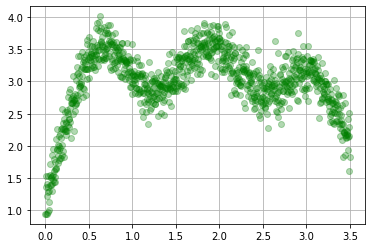

In [5]:
plt.plot(frequency_powers, experimental_dlts, 'og', alpha=0.3)
plt.grid()
plt.show()

In [6]:
n_exps = 3

fs = MultiExpFrequencyScan(n_exps=n_exps, 
                           filling_pulse=2*10**-5,
                           n_iters=200,
                           stop_val=10**-5,
                           verbose=False
                          )

fs.fit(X=frequency_powers, y=experimental_dlts)

MultiExpFrequencyScan(filling_pulse=<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2e-05>,
                      n_exps=3, n_iters=200, stop_val=1e-05)

In [7]:
fit_results = fs.fit_results_
fit_results

,loss,n_exps,time_constatn_power_0,amplitude_0,time_constatn_power_1,amplitude_1,time_constatn_power_2,amplitude_2
0,5.729848,3,-3.201033,1.000000,-3.187009,1.000000,-3.006638,1.000000
1,5.49907,3,-3.143371,1.041831,-3.126790,1.042657,-2.910100,1.056734
2,5.263518,3,-3.091594,1.080889,-3.071515,1.082567,-2.803893,1.113221
3,5.013475,3,-3.047301,1.117592,-3.022549,1.120135,-2.685392,1.171108
4,4.738357,3,-3.012223,1.152631,-2.981412,1.156017,-2.552831,1.232584
...,...,...,...,...,...,...,...,...
129,0.041285,3,-3.488773,2.527366,-2.295029,2.953173,-1.001901,3.514670
130,0.041273,3,-3.488969,2.527008,-2.295105,2.954153,-1.001857,3.514589
131,0.041263,3,-3.489160,2.526653,-2.295178,2.955108,-1.001814,3.514506
132,0.041252,3,-3.489345,2.526300,-2.295250,2.956038,-1.001772,3.514422


In [8]:
fs.exps_params_

array([[-3.48969877,  2.52560171],
       [-2.29538788,  2.95782698],
       [-1.0016922 ,  3.51425096]])

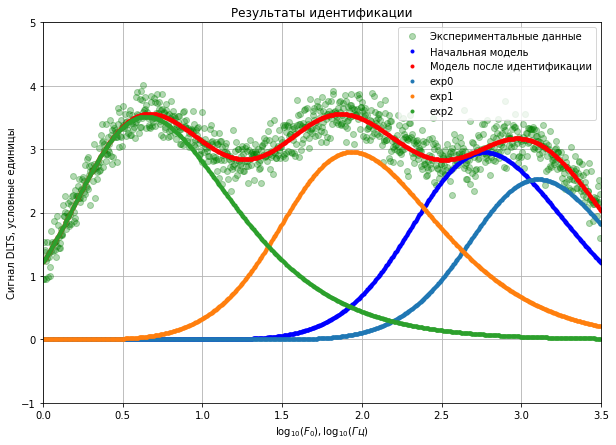

In [9]:
def plot_ident_res(frequency_powers,
                   experimental_dlts, 
                   fit_results,
                   filling_pulse,
                  ):
    
    n_exps=fit_results.loc[0, 'n_exps']
    
    init_params = fit_results.iloc[0, :]
    init_params = [[init_params[f'time_constatn_power_{i}'], init_params[f'amplitude_{i}']] for i in range(n_exps)]
    
    fs = MultiExpFrequencyScan(n_exps=n_exps, filling_pulse = filling_pulse)
    fs.exps_params_ = init_params
    
    initial_model = fs.predict(frequency_powers)
    
    
    final_params = fit_results.iloc[-1, :]
    final_params = [[final_params[f'time_constatn_power_{i}'], final_params[f'amplitude_{i}']] for i in range(n_exps)]
    
    fs.exps_params_=final_params
    final_model = fs.predict(frequency_powers)
    

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))

    ax.plot(frequency_powers, experimental_dlts, 'og', alpha=0.3, label='Экспериментальные данные')

    ax.plot(frequency_powers, initial_model, '.b', label='Начальная модель')

    ax.plot(frequency_powers, final_model, '.r', label='Модель после идентификации')

    for i, scan in enumerate(fs._fs_list):
        plt.plot(frequency_powers, scan(frequency_powers), '.', label=f'exp{i}')

    ax.legend()
    ax.grid()
    ax.set_xlim([0, 3.5])
    ylim = ax.get_ylim()
    ylim = [np.floor(ylim[0]), np.ceil(ylim[1])]
    ax.set_ylim(ylim)
    
    ax.set_title('Результаты идентификации')
    ax.set_xlabel(r'$\log_{10}(F_0), \log_{10}(Гц)$')
    ax.set_ylabel('Сигнал DLTS, условные единицы')
    
    return fig, ax



fig, ax = plot_ident_res(frequency_powers,
                         experimental_dlts, 
                         fit_results,
                         filling_pulse=20*10**-6
                        )

plt.show()

In [10]:
fs.get_params()

{'filling_pulse': <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2e-05>,
 'learning_rate': 0.1,
 'n_exps': 3,
 'n_iters': 200,
 'stop_val': 1e-05,
 'verbose': False}

In [11]:
fs.set_params(n_exps=4)

MultiExpFrequencyScan(filling_pulse=<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2e-05>,
                      n_exps=4, n_iters=200, stop_val=1e-05)

In [12]:
fs.get_params()

{'filling_pulse': <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2e-05>,
 'learning_rate': 0.1,
 'n_exps': 4,
 'n_iters': 200,
 'stop_val': 1e-05,
 'verbose': False}

In [13]:
fs.score(X=frequency_powers, y=experimental_dlts)

0.8420111707526461

In [14]:
fs.predict(X=frequency_powers)

array([1.21933988, 1.23334276, 1.2474401 , 1.26163125, 1.27591555,
       1.2902923 , 1.30476075, 1.31932013, 1.33396962, 1.34870837,
       1.3635355 , 1.37845008, 1.39345115, 1.40853771, 1.42370873,
       1.43896312, 1.45429978, 1.46971756, 1.48521526, 1.50079166,
       1.51644549, 1.53217545, 1.54798018, 1.56385832, 1.57980843,
       1.59582906, 1.61191871, 1.62807585, 1.64429889, 1.66058623,
       1.67693622, 1.69334717, 1.70981735, 1.726345  , 1.74292833,
       1.7595655 , 1.77625463, 1.79299383, 1.80978115, 1.82661461,
       1.8434922 , 1.86041188, 1.87737158, 1.89436917, 1.91140253,
       1.92846946, 1.94556779, 1.96269525, 1.9798496 , 1.99702854,
       2.01422975, 2.03145088, 2.04868955, 2.06594337, 2.08320991,
       2.10048673, 2.11777135, 2.13506127, 2.15235398, 2.16964695,
       2.18693762, 2.20422342, 2.22150175, 2.23877001, 2.25602558,
       2.27326581, 2.29048806, 2.30768967, 2.32486795, 2.34202024,
       2.35914382, 2.37623601, 2.3932941 , 2.41031536, 2.42729

# K-fold Cross-Validation and hyperparameter tuning

In [15]:
X_train, X_test, y_train, y_test = train_test_split(frequency_powers, experimental_dlts, test_size=0.2)

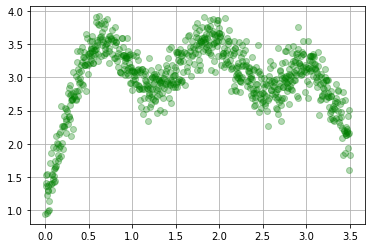

In [16]:
plt.plot(X_train, y_train, 'og', alpha=0.3)
plt.grid()
plt.show()

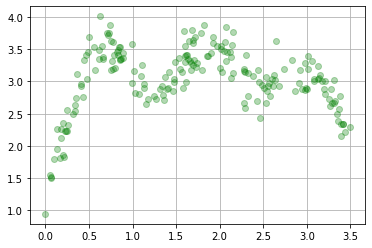

In [17]:
plt.plot(X_test, y_test, 'og', alpha=0.3)
plt.grid()
plt.show()

In [18]:
fs = MultiExpFrequencyScan(n_exps=2,
            filling_pulse=2*10**-5,
            n_iters=200,
            stop_val=10**-5,
            verbose=False
           )

fs.fit(X=X_train, y=y_train)

MultiExpFrequencyScan(filling_pulse=<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2e-05>,
                      n_exps=2, n_iters=200, stop_val=1e-05)

In [19]:
def display_scores(scores):
    print(f'Scores: {scores}')
    print(f'Mean: {scores.mean()}')
    print(f'Standard deviation: {scores.std()}')

scores = cross_val_score(fs, X_train, y_train, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)

display_scores(np.sqrt(-scores))

Scores: [0.80784986 0.81933786 0.8789318  0.74501922 0.82053562 0.75546949
 0.80303475 0.83632023 0.82538904 0.81515121]
Mean: 0.8107039082116267
Standard deviation: 0.03626315180484976


In [20]:
fs.fit_results_

,loss,n_exps,time_constatn_power_0,amplitude_0,time_constatn_power_1,amplitude_1
0,5.487915,2,-2.101569,1.000000,-2.292118,1.000000
1,5.131309,2,-2.077629,1.136622,-2.291925,1.134423
2,4.831938,2,-2.046340,1.260580,-2.296450,1.255999
3,4.572085,2,-2.005841,1.373607,-2.308059,1.366383
4,4.331992,2,-1.953445,1.477585,-2.329609,1.467360
...,...,...,...,...,...,...
97,0.652724,2,-1.135284,3.968294,-2.781613,3.720801
98,0.652711,2,-1.135289,3.969358,-2.781724,3.721290
99,0.652699,2,-1.135294,3.970371,-2.781830,3.721747
100,0.652688,2,-1.135299,3.971335,-2.781931,3.722174


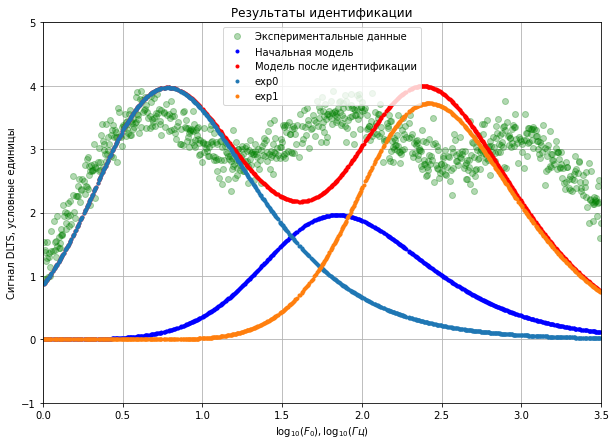

In [21]:
fit_results = fs.fit_results_

fig, ax = plot_ident_res(X_train,
                         y_train, 
                         fit_results,
                         filling_pulse=20*10**-6
                        )

plt.show()

In [22]:
fs = MultiExpFrequencyScan(n_exps=5,
            filling_pulse=2*10**-5,
            n_iters=200,
            stop_val=10**-5,
            verbose=False
           )

fs.fit(X=X_train, y=y_train)

scores = cross_val_score(fs, X_train, y_train, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)

display_scores(np.sqrt(-scores))

Scores: [0.22679934 0.22815565 0.22121804 0.20531765 0.21855993 0.23206612
 0.17318187 0.2012625  0.20164347 0.21691416]
Mean: 0.21251187230086152
Standard deviation: 0.01675189820057668


In [23]:
grid_search = GridSearchCV(fs, {'n_exps':[2,3,4,5,6,7]}, cv=5, scoring='neg_mean_squared_error', 
                           return_train_score=True, n_jobs=-1)

In [24]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=MultiExpFrequencyScan(filling_pulse=<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2e-05>,
                                             n_exps=5, n_iters=200,
                                             stop_val=1e-05),
             n_jobs=-1, param_grid={'n_exps': [2, 3, 4, 5, 6, 7]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [25]:
grid_search.best_params_

{'n_exps': 3}

In [26]:
def display_scores(scores):
    print(f'Scores: {scores}')
    print(f'Mean: {scores.mean()}')
    print(f'Standard deviation: {scores.std()}')

scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)

display_scores(np.sqrt(-scores))

Scores: [0.20133833 0.22335749 0.20659372 0.20028419 0.20953799 0.22169309
 0.17700981 0.1943149  0.20217339 0.19897426]
Mean: 0.2035277167857262
Standard deviation: 0.012628072018008418


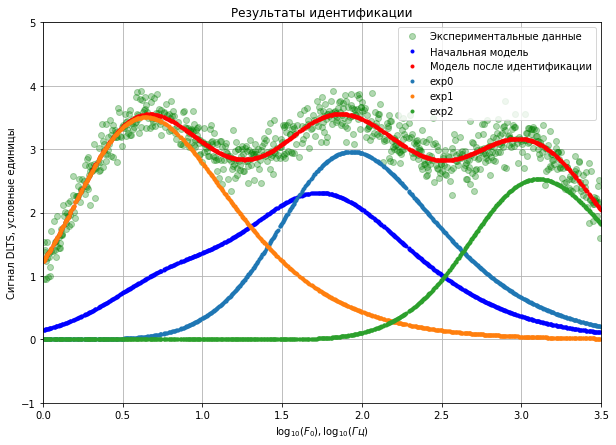

In [27]:
fit_results = grid_search.best_estimator_.fit_results_

fig, ax = plot_ident_res(X_train,
                         y_train, 
                         fit_results,
                         filling_pulse=20*10**-6
                        )

plt.show()

In [28]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, grid_search.best_estimator_.predict(X_test), squared=False)

0.20700725041953583